## Introduction

If GAMA is initialized with `keep_analysis_log` is `True`(default), GAMA will keep a log of the optimization process.
This can give us insight into the optimization process.
In this notebook you will find code which parses and visualizes this log.
It is work in progress, and only meant as a starting point for future analysis.

For any questions, please open a Github Issue.

## Loading and parsing the log

In the code below, make sure to adjust the file path so that it points to your `gama.log` file.
The log *mostly* consists of easy computer parseable lines.
These lines contain multiple values separated by the `;` character, the first value is always `PLE`, the last is `END!`.
The second value we refer to as a *token* which indicates the type of event that is logged, depending on the *token* we can find a different number of fields in the log line.

Example log line for evaluation, starting with `PLE`, ending in `END!` and specifying the `EVAL` token:
```
PLE;EVAL;2018-10-09 12:00:02,660257;2.484375;(-0.6418912065249542, -2);18eb590c-db86-4258-bcee-8d35dda7c4b9;MultinomialNB(MaxAbsScaler(data), alpha=1.0, fit_prior=False);2018-10-09 12:00:06,230066;END!
```

In [93]:
log_filename = 'gama.log'
with open(log_filename, 'r') as log_file:
    log = log_file.readlines()
    
# The first two lines detail the GAMA version as well as GAMA's hyperparameter configuration.
header = log[0] + log[1]
# Each line we are interested in is marked with `PLE` (Parseable Log Event), after which information follows.
log = [line.split('PLE;')[1].split(';END!')[0].split(';') for line in log if 'PLE;' in line]

In [94]:
print(header)

Using GAMA version 0.1.0.
GamaClassifier(cache_dir=None,keep_analysis_log=True,verbosity=30,n_jobs=4,max_eval_time=600,max_total_time=10800,population_size=50,random_state=None,optimize_strategy=(1, -1),objectives=('neg_log_loss', 'size'))



In [95]:
# As stated before, each parseable log event will have a token indicated what type of action it describes.
def log_for_token(token_to_match):
    return [(*args, time) for (token, *args, time) in log if token == token_to_match]
evaluation_lines = log_for_token('EVAL')
timeout_lines = log_for_token('EVAL_TO')
print(f"{len(evaluation_lines)} evaluations of which {len(timeout_lines)} timed out.")

257 evaluations of which 15 timed out.


# Optimization results

**`! WARNING !`** This code may need to be adjusted depending on your run. For instance, it does not automatically adopt to the metric used for optimization (yet).

This section takes a look at the optimization process. What does the optimization over time look like. Descriptions of produced plots can be found *below* the respective plots.

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
from collections import Counter

In [97]:
evaluation_metric = 'neg_log_loss'

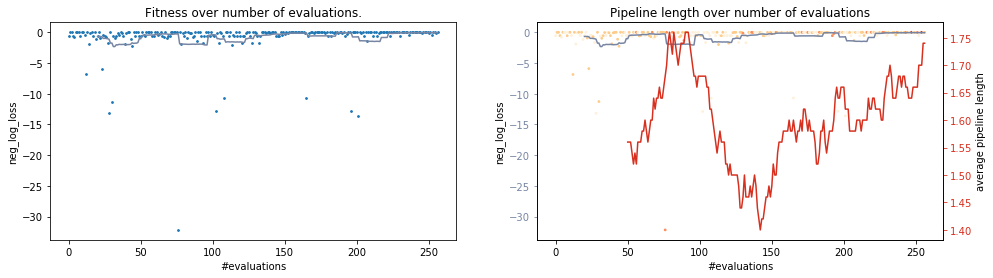

In [98]:
fig = plt.figure(figsize=(16,4))

fitness1_values = [float(fitness.split(',')[0][1:]) for (starttime, duration, fitness, id_, pl, logtime) in evaluation_lines]
fitness1_success_values = [val if val != -float('inf') else 0 for val in fitness1_values]
moving_average_20 = [np.mean(fitness1_success_values[i-20:i]) for i in range(20,len(fitness1_success_values))]
counts = list(range(len(fitness1_success_values)))

ax = fig.add_subplot(121) #RCP
ax.set_title('Fitness over number of evaluations.')
ax.set_xlabel('#evaluations')
ax.set_ylabel(evaluation_metric)
ax.scatter(counts, fitness1_success_values, s=3)
ax.plot(counts[20:], moving_average_20, c='#7785a3')

pl_length_colormap = {1:'#fef0d9', 2:'#fdcc8a', 3:'#fc8d59', 'other':'#d7301f'}
pl_length_values = [pl.count('(') for (start, duration, fitness, id_, pl, time) in evaluation_lines]
moving_average_50_length = [np.mean(pl_length_values[i-50:i]) for i in range(50,len(pl_length_values))]
length_colors = [pl_length_colormap[length] if length <4 else pl_length_colormap['other'] for length in pl_length_values]

right_ax = fig.add_subplot(122)
right_ax.set_title('Pipeline length over number of evaluations')
right_ax.set_xlabel('#evaluations')
right_ax.scatter(counts, fitness1_success_values, s=3, c=length_colors)
right_ax.plot(counts[20:], moving_average_20, c='#7785a3')
right_ax.set_ylabel(evaluation_metric)
right_ax.tick_params('y', colors='#7785a3')
right_ax_twin = right_ax.twinx()
right_ax_twin.plot(counts[50:], moving_average_50_length, c='#d7301f')
right_ax_twin.set_ylabel('average pipeline length')
right_ax_twin.tick_params('y', colors='#d7301f')

In the above two plots, you can see fitness over time. 
Each dot represents one evaluated pipeline. 
The y-axis represents the performance according to the specified metric.
The x-axis denotes the number of evaluations passed.
Note that the (by default), the first `50` evaluations are completely independently generated individuals.
The lines in the graphs represent the moving average of the past 20 evaluations at that point.

In the right figure, evaluations are colored-coded by the pipeline length.
Darker red means a longer pipeline (i.e. containing more preprocessing steps).
The red line is the moving average of pipeline length of the last 20 evaluations.
GAMA by default aims to minimize pipeline length as long as it does not hurt performance.

In [99]:
print(f"Longest pipeline had length of {max(pl_length_values)}.")

Longest pipeline had length of 4.


We want to identify what machine learning algorithms work well during the optimization process.
As a refresher, a *machine learning pipeline* consists of zero or more *preprocessing steps*, followed by a machine learning algorithm which creates a predictive model on the preprocessed data.

We define the final learner component in the pipeline the `main learner`, as it is the learner which does the final prediction. 
We will analyze which `main learners` do well, and which ones do not.
Note that how well a `main learner` performs is also dependent on the preprocessing steps used.
Analysis below does not give a complete picture and can be extended further.

In [100]:
main_learner_color_map = dict(
 BernoulliNB='#a6cee3',
 MultinomialNB='#1f78b4',
 GaussianNB='#195c8a',
 DecisionTreeClassifier='#fdbf6f',
 ExtraTreesClassifier='#e31a1c',
 GradientBoostingClassifier='#ff7f00',
 RandomForestClassifier='#fb9a99',
 KNeighborsClassifier='#a6ff58',
 LinearSVC='#b2df8a',
 LogisticRegression='#cab2d6'
)
main_learners = [pl.split('(')[0] for (starttime, duration, fitness, id_, pl, logtime) in evaluation_lines]

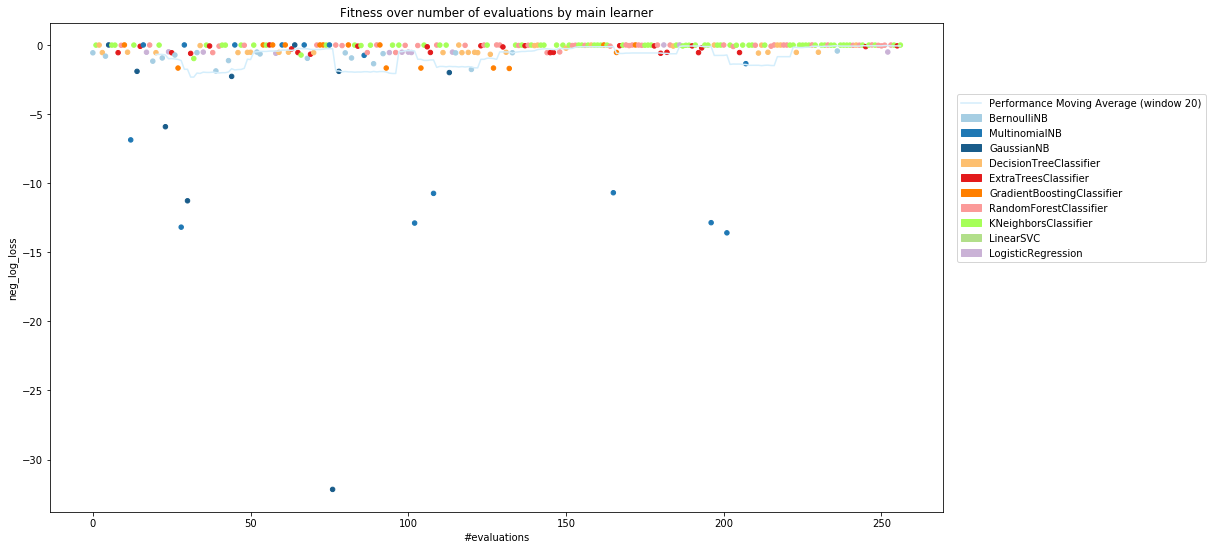

In [101]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111) #RCP
ax.set_title('Fitness over number of evaluations by main learner')
ax.set_xlabel('#evaluations')
ax.set_ylabel(evaluation_metric)

counts = list(range(len(evaluation_lines)))
#fitness_values = [float(line.split(';')[2].split(',')[0][1:]) for line in evaluation_lines]
#fitness_values = [val if val != -float('inf') else 0 for val in fitness_values]
prime_learner_map = [main_learner_color_map[main_learner] for main_learner in main_learners]

ax.plot(counts[20:], moving_average_20, c='#d4eefc', label='Performance Moving Average (window 20)')
ax.scatter(counts, fitness1_success_values, s=20, c=prime_learner_map)

for main_learner, color in main_learner_color_map.items():
    patch = mpatches.Rectangle([0, 0], 0, 0, facecolor=color, edgecolor=color, label=main_learner)
    ax.add_patch(patch)
    
ax.legend(bbox_to_anchor=(1.30, 0.5), loc=4)

Above figure again shows the performance of the evaluated individuals over time, where each evaluation is represented by one dot.
The dot is color-coded to show the `main learner` of the pipeline.
Typical behavior is that the initial population is varied, but over time pipelines tend to converge to a local optimum.

Next, we compare *all* pipeline performances against each other.

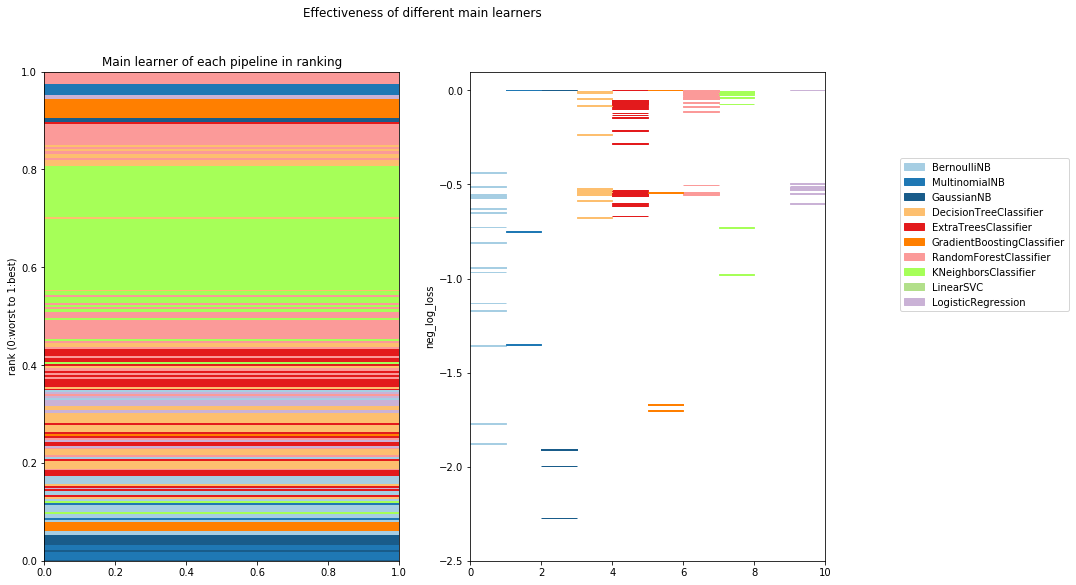

In [109]:
nr_evaluations = len(evaluation_lines)
line_width = 1
line_height = 1 / nr_evaluations

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(121) #RCP

for rank, (value, learner) in enumerate(sorted(zip(fitness1_success_values, main_learners))):
    color = main_learner_color_map[learner]
    patch = mpatches.Rectangle([0, rank/nr_evaluations], line_width, line_height, facecolor=color, edgecolor=color)
    ax.add_patch(patch)
ax.set_title('Main learner of each pipeline in ranking')
ax.set_ylabel('rank (0:worst to 1:best)')
    
ax2 = fig.add_subplot(122) #RCP
for rank, (value, learner) in enumerate(sorted(zip(fitness1_success_values, main_learners))):
    color = main_learner_color_map[learner]
    learner_x = dict(zip(main_learner_color_map,range(len(main_learner_color_map))))
    patch = mpatches.Rectangle([learner_x[learner], value], line_width, line_height, facecolor=color, edgecolor=color)
    ax2.add_patch(patch)
ax2.set_xlim([0,len(main_learner_color_map)])
ax2.set_ylim([-2.5, 0.1])
ax2.set_label('Evaluation score by pipeline by main learner.')
ax2.set_ylabel(evaluation_metric)

for main_learner, color in main_learner_color_map.items():
    patch = mpatches.Rectangle([0, 0], 0, 0, facecolor=color, edgecolor=color, label=main_learner)
    ax2.add_patch(patch)

ax2.legend(bbox_to_anchor=(1.70, 0.5), loc=4)
fig.suptitle('Effectiveness of different main learners')

In the left figure, we see a ranking of the pipelines by evaluation score, from 0 (lowest) to 1 (highest). Each pipeline is represented by a horizontal stripe in the color of its `main learner`.

Because ranking loses information about the absolute differences, and two pipelines with the same score but different learner will be ordered arbitrarily in a ranking, the plot on the right is created.
The plot on the right shows evaluation score per `main learner`.

**`! WARNING !`** The y-axis scale of the right figure is not adaptive (yet), adjust it in the code to look at the range that makes sense.

## Issues during evaluation

Some pipelines might not even finish an evaluation successfully. Some might exceed the runtime, others might run into more technical issues (such as not being able to cope with certain data). We inspect the main issues, and which learners experience trouble.

When evaluating a pipeline exceeds the limit, the following log entry is produced:
```
PLE;EVAL_TO;2018-10-09 12:04:07,490154;Pipeline(memory=None,     steps=[('StandardScaler0', StandardScaler(copy=True, with_mean=True, with_std=True)), ('KNeighborsClassifier0', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',           metric_params=None, n_jobs=1, n_neighbors=27, p=1,           weights='uniform'))]);2018-10-09 12:10:07,234031;END!
```

For runtime errors, we get output like:
```
PLE;EVAL_ERR;2018-10-09 12:10:19,775965;Pipeline(memory=None,     steps=[('FastICA0', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,    n_components=None, random_state=None, tol=1.0, w_init=None,    whiten=True)), ('MultinomialNB0', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=False))]);<class 'ValueError'>;Input X must be non-negative;2018-10-09 12:10:20,502983;END!
```

In [121]:
error_lines[4]

('2018-10-22 18:03:15,043759',
 "Pipeline(memory=None,     steps=[('FeatureAgglomeration0', FeatureAgglomeration(affinity='cosine', compute_full_tree='auto',           connectivity=None, linkage='average', memory=None, n_clusters=2,           pooling_func=<function mean at 0x00000182D2EFA9D8>)), ('RBFSampler0', RBFSampler(gamma=0.65, n_components=100, ran...imators=100, n_jobs=1,           oob_score=False, random_state=None, verbose=0, warm_start=False))])",
 "<class 'ValueError'>",
 'The condensed distance matrix must contain only finite values.',
 '2018-10-22 18:03:15,278767')

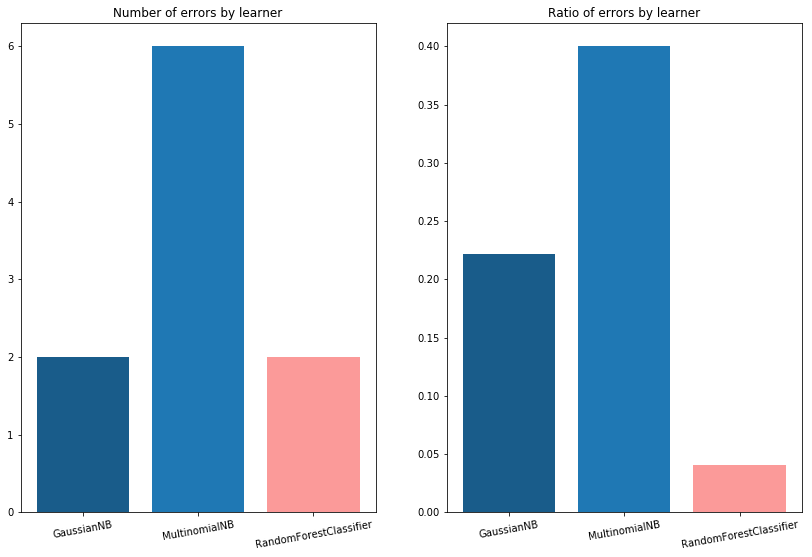

In [122]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(121) #RCP

error_lines = log_for_token('EVAL_ERR')
errors = [e.split("<class '")[1].split("'>")[0] for (time, pl, e, emessage, time2) in error_lines]
error_messages = [emessage for (time, pl, e, emessage, time2) in error_lines]
#error_learner = [pl.split(']')[0].split("'")[-2].split("'")[-1] for (time, pl, e, emessage, time2) in error_lines]
error_learner = [pl.split(']')[0].split("(")[-2].split("'")[-1][2:] for (time, pl, e, emessage, time2) in error_lines]

count_error_learner = Counter([learner for learner in error_learner if learner in main_learner_color_map])
count_error_learner_colormap = [main_learner_color_map[name] for name in count_error_learner]
count_main_learner = Counter(main_learners)

main_learner_color_map
ax.bar(range(len(count_error_learner)), list(count_error_learner.values()), color=count_error_learner_colormap)
ax.set_title('Number of errors by learner')
ax.set_xticklabels(list(count_error_learner), rotation=10)
ax.set_xticks(range(len(count_error_learner)))
right_ax = fig.add_subplot(122) #RCP
right_ax.set_title('Ratio of errors by learner')
ratios = [fail_count/count_main_learner[learner] for learner, fail_count in count_error_learner.items()]
right_ax.bar(range(len(count_error_learner)), ratios, color=count_error_learner_colormap)
right_ax.set_xticklabels(list(count_error_learner), rotation=10)
right_ax.set_xticks(range(len(count_error_learner)))

Above figures give an overview of the errors encountered during evalatuation grouped by `main learner`.
On the left you see the absolute numbers, on the right the ratio of errors (total number of errors for the `main learner` divided by the total number of pipelines evaluated with that `main learner`).

**IMPORTANT:** The errors here are attributed to the `main learner`, eventhough they might have ocurred at a preprocessing step.

**TODO: improve logging to see at which component the crash ocurred (if possible). **

## Resource Usage

Not every machine learning pipeline takes equally long to be evaluated.
Gaining insight into which 

**IMPORTANT:** Here too, one should keep in mind that the runtime is not solely determined by the `main learner`. Preprocessing steps can take up a significant amount of time. Measuring time spent per component likely will require significant code changes. While it is something that we hope to include in the future, it will not be added soon.

In [123]:
from datetime import datetime
time_format = '%Y-%m-%d %H:%M:%S,%f'
# Figure out total runtime (there may be an otherwise undetermined amount of time after the last evaluation result came in)
#2018-07-27 11:09:33,889 [INFO] gama.gama -- Search phase took 269.3711s. Moving on to post processing
#2018-08-03 18:20:15,341     INFO Search phase took 269.0708s. Moving on to post processing. [gama.py:224]
search_start, = [datetime.strptime(time, time_format) for (token, *args, time) in log if 'PRE_END' in token]
search_time, = [float(args[0]) for (token, *args, time) in log if 'S_END' in token]

runtime_values = [max(0, float(duration)) for (start, duration, fitness, id_, pl, time) in evaluation_lines]
#runtime_ratios = [dur/search_time for dur in runtime_values]
#end_times = [datetime.strptime(logtime, time_format) for (starttime, duration, fitness, pl, logtime) in evaluation_lines]
start_times = [datetime.strptime(starttime, time_format) for (starttime, duration, fitness, id_, pl, logtime) in evaluation_lines]
relative_start_times = [(eval_start-search_start).total_seconds() for eval_start in start_times]
#relative_start_times = [(end-search_start).total_seconds() - duration for duration, end in zip(runtime_values, end_times)]
relative_end_times = [eval_start+duration for eval_start, duration in zip(relative_start_times, runtime_values)]

#relative_timeout = [((datetime.strptime(start, time_format) - search_start).total_seconds(), 300, pl.split('(')[0]) for (start, pl, end) in timeout_lines]
all_evaluations = list(zip(relative_start_times, runtime_values, main_learners))# + relative_timeout

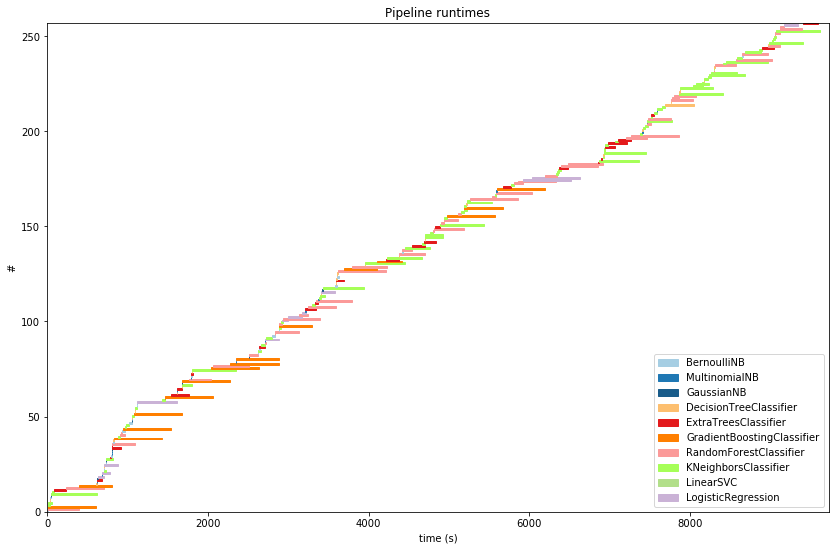

In [124]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111) #RCP
for order, (start, duration, learner) in enumerate(sorted(all_evaluations)):
    color = main_learner_color_map[learner]
    patch = mpatches.Rectangle([start, order], duration, 1, facecolor=color, edgecolor=color)
    ax.add_patch(patch)
    
ax.set_title('Pipeline runtimes')
ax.set_xlabel('time (s)')
ax.set_ylabel('#')
ax.set_xlim([0, search_time])
ax.set_ylim([0, len(runtime_values)])

for main_learner, color in main_learner_color_map.items():
    patch = mpatches.Rectangle([0, 0], 0, 0, facecolor=color, edgecolor=color, label=main_learner)
    ax.add_patch(patch)

ax.legend(loc=4)

#ax.set_ylim([800, 900])
#ax.set_xlim([1000, 1300])

Above figure shows the evalution time per pipeline. Each bar represents one evaluation with a start time and end time, which makes the length of a bar correspond to the duration of the evaluation. The y-axis indicates how many pipelines finished evaluation before it.

For the first few seconds, no evaluations take place as GAMA is setting up additional processes for parallel pipeline evaluation.

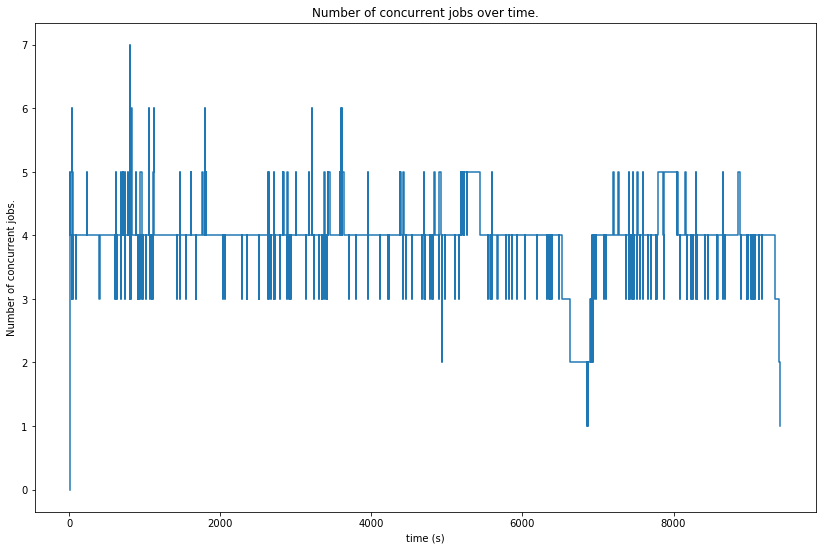

In [125]:
#graph number of concurrent evaluations:
end_time_idx = 0
concurrency_counter = 0
points = []
sorted_start_times = list(sorted(relative_start_times))
sorted_end_times = list(sorted(relative_end_times))
for start_time, next_start_time in zip(sorted_start_times, sorted_start_times[1:]):    
    points.append((start_time, concurrency_counter))
    concurrency_counter += 1
    points.append((start_time, concurrency_counter))
    for end_time in sorted_end_times[end_time_idx:]:
        if next_start_time > end_time:
            points.append((end_time, concurrency_counter))
            concurrency_counter -= 1
            points.append((end_time, concurrency_counter))
            end_time_idx += 1
        else:
            break
            
# Ignore the last point because there are inaccuracies anyway because the last evaluations get killed without log output.
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111)
ts, cs = zip(*points)
ax.plot(ts, cs)
ax.set_title('Number of concurrent jobs over time.')
ax.set_xlabel('time (s)')
ax.set_ylabel('Number of concurrent jobs.')    
#ax.set_xlim([1221,1270])

Above figure shows the number of pipelines evaluated simultaneously at any one time.
One should see mostly a steady line at `n_jobs` (4 in this example), sometimes dropping lower when a process is in-between evaluations.
Especially when evaluations are *very* short, it seems less consistent.

**Note:** *I am not sure what exactly causes the extra spikes, I guess somehow inaccurate time measurements.*

## Effect of mutations

An evolutionary algorithm explores the pipeline space by performing *crossover* and *mutation*.
The goal of these operators is to do local exploration based on solutions that worked well.
By gaining insight into which mutation operators work well in the AutoML setting, we might be able to perform more efficient optimization.

In [126]:
mutation_lines = [(*args, time) for (token, *args, time) in log if token == 'IND_MUT']

In [127]:
def fitness_str_to_score(string):
    return float(string.split(',')[0][1:])

In [128]:
evaluations = {id_ : (pipeline, fitness_str_to_score(fitness)) 
               for (start, duration, fitness, id_, pipeline, logtime) in evaluation_lines}

In [129]:
cnt = 0
for child, parent, method, time in mutation_lines:
    if evaluations.get(parent):
        cnt += 1
    else:
        print(parent, method)

assert cnt/len(mutation_lines) == 1.0, "Every mutation should come from a parent with an evaluation."

In [130]:
import math
from collections import defaultdict

performance_differences = defaultdict(list)
mutate_to_fail = defaultdict(int)
mutate_count = defaultdict(int)
for child, parent, method, time in mutation_lines:
    if child in evaluations:
        mutate_count[method] += 1
        performance_increase = (evaluations[child][1] - evaluations[parent][1])
        if not (math.isnan(performance_increase) or math.isinf(performance_increase)):
            performance_differences[method].append(performance_increase)
        else:
            mutate_to_fail[method] += 1


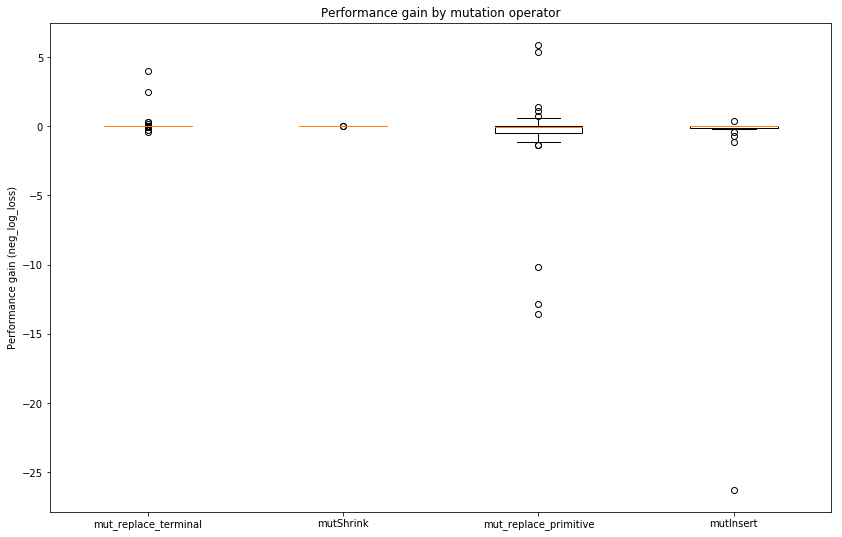

In [131]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111) #RCP
ax.boxplot(list(performance_differences.values()))
ax.set_xticklabels(list(performance_differences.keys()), rotation=0)
ax.set_ylabel('Performance gain ({})'.format(evaluation_metric))
ax.set_title('Performance gain by mutation operator')

Above figure depicts the changes in performance for each mutation operator.
The values shown above depict the performance difference `child - parent`, meaning that a score that you want to maximize (like f1-macro or negative log loss), higher values are better.

## End Note

This is as far as the analysis goes for now.
Over time, we hope to make the analysis more expansive, easily extendable and even update on the fly for a currently running optimization process.
If you have any questions or suggestions, the best way to get in touch is through Github Issues.